In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, confusion_matrix, roc_auc_score, accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm 

Возраст: возраст в годах, когда женщина беременна.  
Систолическое давление: верхнее значение артериального давления в мм рт. ст., еще один важный атрибут во время беременности.  
Диастолическое давление: нижнее значение артериального давления в мм рт. ст., еще один важный атрибут во время беременности.  
BS: уровень глюкозы в крови в молярной концентрации, ммоль/л.   
BodyTemp: Температура тела в Фаренгейтах  
HeartRate: Нормальная частота сердечных сокращений в состоянии покоя в ударах в минуту.  
Уровень риска: Прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего атрибута.  

In [5]:
# Начнем с чтения csv данных
data = pd.read_csv('Maternal Health Risk Data Set.csv')
data.describe()


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [6]:

label_counts = data["RiskLevel"].value_counts()
print(label_counts)


RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


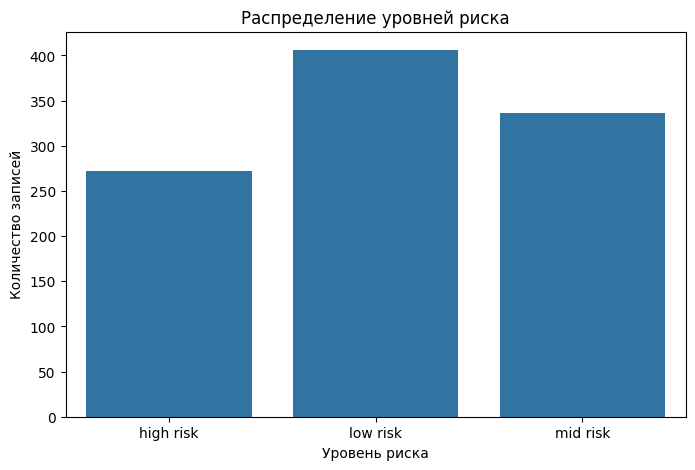

In [7]:
#Посмотрим на распределние уровней риска
plt.figure(figsize=(8, 5))
sns.countplot(x='RiskLevel', data=data)
plt.title('Распределение уровней риска')
plt.xlabel('Уровень риска')
plt.ylabel('Количество записей')
plt.show()

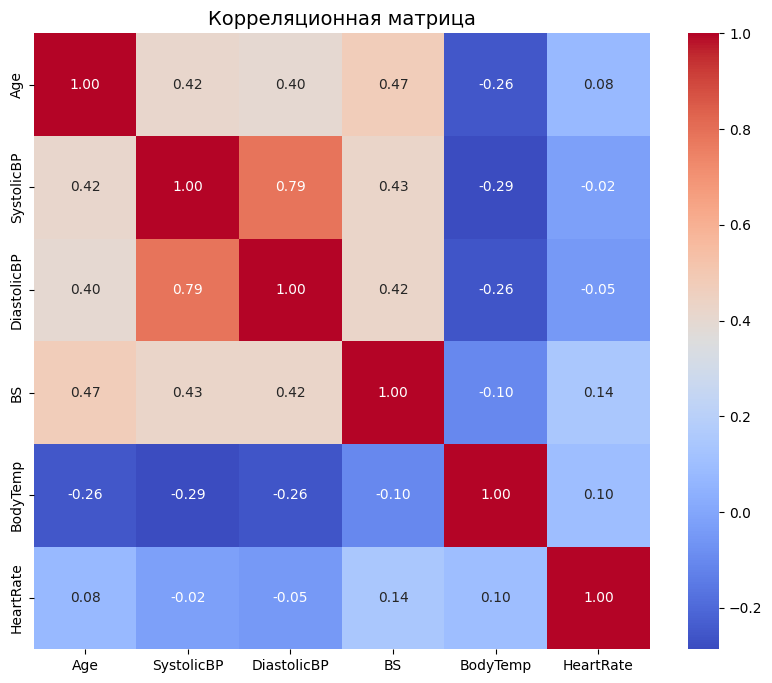

In [8]:
#Посмотрим на матрицу корреляций
plt.figure(figsize=(10, 8))
correlation_matrix = data.drop('RiskLevel', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

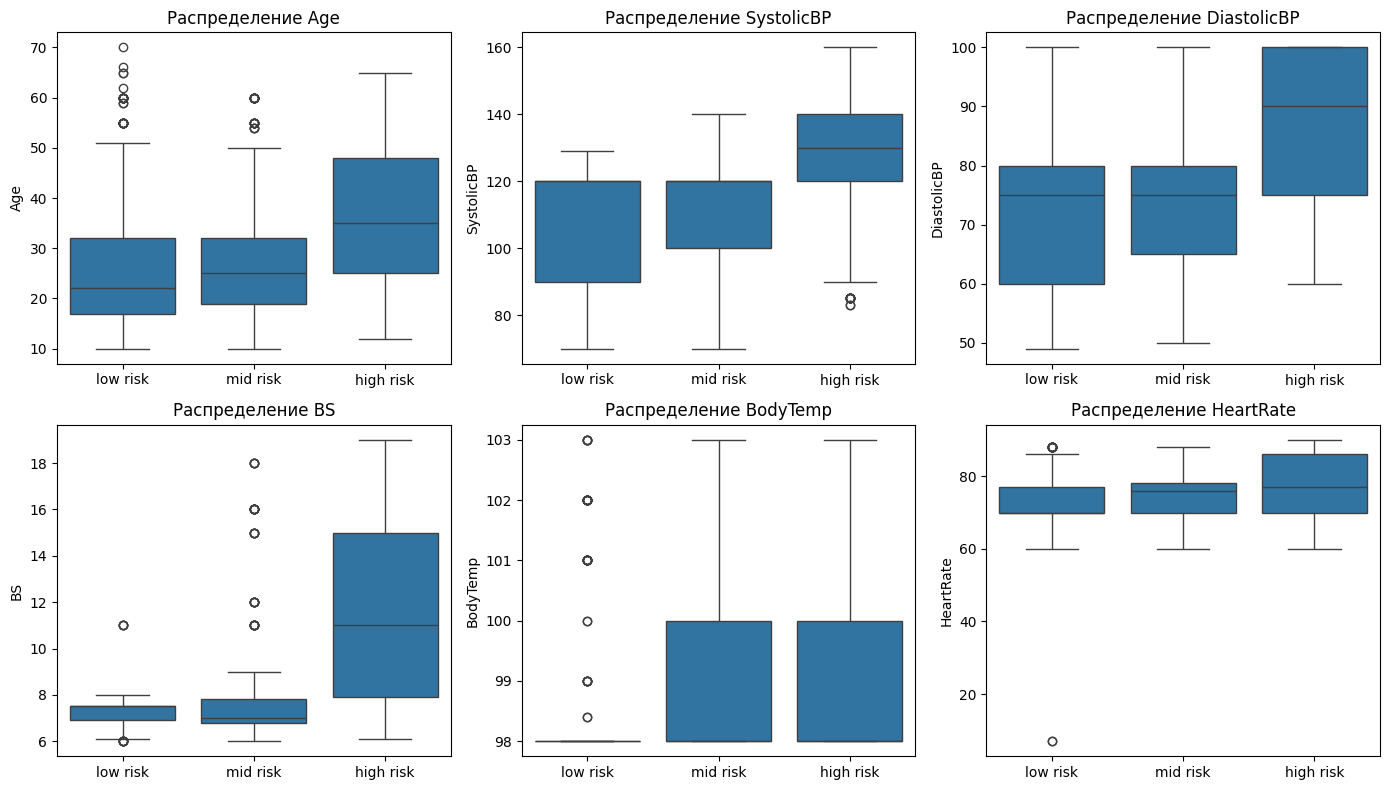

In [9]:
plt.figure(figsize=(14, 8))
for i, column in enumerate(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='RiskLevel', y=column, data=data, order=['low risk', 'mid risk', 'high risk'])
    plt.title(f'Распределение {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel(column, fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
# Преобразуем метку из категориальных значений в числовые
risk_level_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
data['RiskLevelEncoded'] = data['RiskLevel'].map(risk_level_mapping)
# Удаляем столбец RiskLevel оставляя только числовую фичу
data = data.drop(columns=['RiskLevel'])
data

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevelEncoded
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2
1012,43,120,90,18.0,98.0,70,2


In [11]:
# Преобразование температуры из Фаренгейта в Цельсий
data['BodyTemp_C'] = (data['BodyTemp'] - 32) * 5 / 9

In [12]:
# Округлим температуру до 1 числа посел запятой
data['BodyTemp_C'] = data['BodyTemp_C'].round(1)

In [13]:
# Создание нового признака: отношение SystolicBP к DiastolicBP
data['BP_Ratio'] = data['SystolicBP'] / data['DiastolicBP']


In [14]:
# Стандартизируем наши данные

# Выделяем числовые признаки
numerical_features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'HeartRate', 'BodyTemp_C']

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Проверяем результат
data.sample(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevelEncoded,BodyTemp_C,BP_Ratio
1,0.380777,1.457027,0.975539,1.298340,98.0,-0.532088,2,-0.483797,1.555556
909,-1.104253,0.369765,0.255023,-0.250914,98.0,-0.532088,0,-0.483797,1.500000
266,-0.138984,-1.261127,-1.186009,-0.554689,98.0,0.952195,0,-0.483797,1.500000
741,-0.807247,0.369765,0.255023,-0.524312,98.0,-0.532088,1,-0.483797,1.500000
238,-0.955750,-1.261127,-0.969854,-0.220537,101.0,-0.532088,2,1.667828,1.428571
628,-1.104253,0.369765,0.255023,-0.372424,98.0,-0.532088,0,-0.483797,1.500000
933,-0.138984,-1.261127,-1.186009,-0.372424,98.0,0.952195,0,-0.483797,1.500000
987,-0.955750,-1.261127,-0.969854,-0.220537,101.0,-0.532088,2,1.667828,1.428571
257,-0.658744,-1.261127,-0.825751,-0.554689,98.0,0.210054,0,-0.483797,1.384615
70,-0.287487,-1.532942,-1.186009,-0.828087,101.0,1.446956,1,1.667828,1.416667


In [15]:
# Разделим данные на 3 группы train test и validation

# Сначала делим данные на тренировочный + временный (валидация + тест)
X_temp, X_test, y_temp, y_test = train_test_split(
    data.drop(columns=['RiskLevelEncoded']),  # Признаки
    data['RiskLevelEncoded'],                 # Целевая переменная
    test_size=0.2,                            # 20% данных для теста
    random_state=42, stratify=data['RiskLevelEncoded'] # Для сохранения пропорций классов
)

# Далее делим временный набор на тренировочный и валидационный
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,                           # 25% от временных данных (итого 20% от всего набора)
    random_state=42, stratify=y_temp          # Сохраняем пропорции классов
)

# Проверим размеры наборов
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")



Train set: (608, 8), Validation set: (203, 8), Test set: (203, 8)


In [16]:
# Определяем Random Forest для вывода прогресса, с использованием tqdm
class RandomForestWithProgress(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        self.n_estimators_ = 0  # Счётчик для отображения прогресса
        self.estimators_ = []
        for _ in tqdm(range(self.n_estimators), desc="Обучение деревьев"):
            super().fit(X, y, sample_weight=sample_weight)
            self.n_estimators_ += 1  # Обновляем прогресс
        return self

# Создаём модель Random Forest с отслеживанием прогресса
rf_model = RandomForestWithProgress(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)  # Обучение модели

Обучение деревьев: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


RandomForestWithProgress(class_weight='balanced', random_state=42)

In [17]:
print("=== Test Set Metrics ===")
# Оценка Accuracy
accuracy = rf_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

# Предсказания на тестовом наборе
y_pred = rf_model.predict(X_test)

# Подробный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# AUC-ROC
y_proba = rf_model.predict_proba(X_test)  # Предсказания вероятностей
auc_scores = roc_auc_score(y_test, y_proba, multi_class='ovo')
print(f"\nAUC-ROC: {auc_scores:.2f}")

=== Test Set Metrics ===
Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        81
           1       0.78      0.79      0.79        67
           2       0.88      0.95      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203


Confusion Matrix:
[[65 15  1]
 [ 8 53  6]
 [ 3  0 52]]

AUC-ROC: 0.95


In [18]:
print("=== Validation Set Metrics ===")
y_val_pred = rf_model.predict(X_val)  # Предсказания
y_val_proba = rf_model.predict_proba(X_val)  # Предсказания вероятностей

# Метрики
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))

# AUC-ROC для валидационного набора
val_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovo')
print(f"AUC-ROC (Validation): {val_auc:.2f}")


=== Validation Set Metrics ===
Validation Accuracy: 0.85
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.81      0.81      0.81        67
           2       0.89      0.89      0.89        54

    accuracy                           0.85       203
   macro avg       0.85      0.85      0.85       203
weighted avg       0.85      0.85      0.85       203

Confusion Matrix (Validation):
[[71 11  0]
 [ 7 54  6]
 [ 4  2 48]]
AUC-ROC (Validation): 0.94


### Метрики  
**Validation Accuracy**: 0.85  

Это достаточно хороший результат для валидационной выборки. Он говорит о том, что 85% предсказаний модели на валидационных данных были правильными.  
Classification Report (Validation):  

**Precision**: Средняя точность (precision) для каждого класса хорошая, особенно для класса 2 (high risk), где она составляет 0.89. Для класса 1 (mid risk) точность несколько ниже — 0.81.  
**Recall**: Особенно хорош recall для класса 2 (0.89), что показывает, что модель хорошо обнаруживает все случаи этого класса. Однако, для класса 1 recall чуть ниже (0.81).  
**F1-score**: Для всех классов F1-score выглядит сбалансированным. Лучше всего он для класса 2 (0.89).  
**Support**: Это количество примеров для каждого класса в валидационном наборе.    

**Confusion Matrix (Validation)**:  
Для каждого класса можно увидеть, как часто модель ошибается. Например, для класса 0 (low risk) она ошибается 11 раз, для класса 1 (mid risk) — 6 раз, а для класса 2 (high risk) — 4 раза. Ошибки между классами низки, что указывает на хорошее разделение классов.  

**AUC-ROC (Validation)**: 0.94  
AUC-ROC = 0.94 — это очень хороший показатель, особенно для многоклассовой задачи. Это указывает на высокую способность модели различать классы.

**Заключение**:  
Результаты на валидационном наборе показывают, что модель хорошо работает, с точностью около 85%, и с хорошими значениями precision, recall и F1 для всех классов. AUC-ROC 0.94 подтверждает, что модель хорошо различает все классы.